# This notebook is to use CmapPy to query LINCS1000

In [1]:
import sys
sys.path.append("../..")
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np
from sys import platform 
from cmapPy.pandasGEXpress.parse import parse
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
plt.rcParams.update({'font.size':18})
%matplotlib inline
%load_ext autoreload
%autoreload 2
prefix = 'G:' if platform == 'win32' else '/Volumes/GoogleDrive'

## Step 1: get critical genes that are DEG regulators

In [2]:
deg_regulators = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/IPA analysis/deseq_upstream_regulators_unfiltered.csv')
deg_regulators_sig = deg_regulators[deg_regulators['p-value of overlap'] < 0.05]['Upstream Regulator']
gene_mapping = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/feature_extraction_derived/gene_mapping_df.csv')
gene_mapping_dict = pd.Series(gene_mapping.symbol.values, index = gene_mapping.id.values).to_dict()
cg_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/feature_extraction_derived/epoch=100_alpha=0.1_critical_gene_df.csv')
cg_df = cg_df.assign(symbol = cg_df['gene'].map(gene_mapping_dict))

## Step 2: determine if these DEGs are up or down regulated and if these critical genes are positively or negatively correlated with the DEGs

In [3]:
deg_regulators_sig_df = deg_regulators[deg_regulators['p-value of overlap'] < 0.05]

### Loop through regulator and DEG pairs since each regulator has multiple targets 

In [4]:
regulator_list = []
deg_list = []
for i in range(len(deg_regulators_sig_df)):
    for deg in deg_regulators_sig_df['Target Molecules in Dataset'].str.split(',')[i]:
        regulator_list.append(deg_regulators_sig_df['Upstream Regulator'][i])
        deg_list.append(deg)

In [5]:
reg_deg_df = pd.DataFrame({'regulator': regulator_list, 'deg': deg_list})

In [6]:
deseq = pd.read_excel(prefix +'/Shared drives/NIAAA_ASSIST/Data/deseq.alc.vs.control.age.rin.batch.gender.PMI.corrected.w.prot.coding.gene.name.xlsx')
expression = pd.read_csv(prefix + 'Shared drives/NIAAA_ASSIST/Data/kapoor_expression_Apr5.txt', sep = '\t', index_col = 0)
symbols = list(expression.index.map(gene_mapping_dict))
expression.index = symbols

In [7]:
reg_deg_df = pd.merge(reg_deg_df, deseq, left_on = 'deg', right_on = 'gene')
cg_deg_df = reg_deg_df[reg_deg_df['regulator'].isin(cg_df['symbol'])]
cg_deg_df = cg_deg_df.reset_index(drop = True)

## Step 3: determine if the drug should activate or inhibit CG based on the direction of correlation and log2FC

### How to order the list for querying LINCS?
### Based on absolute regulator and deg correlation and then the size of abs(log2FC) from high to low

In [8]:
# get the regulator and deg gene correlation coefficients
reg_deg_corr = []
for i in range(len(cg_deg_df)):
    reg = cg_deg_df['regulator'][i]
    deg = cg_deg_df['deg'][i]
    reg_expr = expression.loc[reg]
    deg_expr = expression.loc[deg]
    reg_deg_corr.append(pearsonr(reg_expr, deg_expr)[0])

In [9]:
# critical genes (also DEG regulators) and DEG df
cg_deg_df['reg_deg_corr'] = reg_deg_corr
cg_deg_df['abs_reg_deg_corr'] = np.abs(reg_deg_corr) # get absolute correlation coefficients
cg_deg_df['abs_log2FC'] = np.abs(cg_deg_df['log2FoldChange']) # get absolute log2FC
sorted_cg_deg = cg_deg_df.sort_values(['abs_reg_deg_corr','abs_log2FC'], ascending = False)

In [ ]:
# If log2FC > 0 and corr > 0, find drugs that inhibit the CG
# if log2FC > 0 and corr < 0, find drugs that activate the CG
# if log2FC < 0 and corr > 0, find drugs that activate the CG
# if log2FC < 0 and corr < 0, find drugs that inhibit the CG

In [10]:
sorted_cg_deg['drug_type'] = 'inhibitor'
sorted_cg_deg.loc[(sorted_cg_deg['log2FoldChange'] > 0) & (sorted_cg_deg['reg_deg_corr'] < 0), 'drug_type'] = 'activator'
sorted_cg_deg.loc[(sorted_cg_deg['log2FoldChange'] < 0) & (sorted_cg_deg['reg_deg_corr'] > 0), 'drug_type'] = 'activator'

## Step 4: Query LINCS

In [11]:
sig_info = pd.read_csv(prefix + "/Shared drives/NIAAA_ASSIST/Data/LINCS L1000 (from GEO)/Phase I/GSE92742_Broad_LINCS_sig_info.txt.gz", 
                       sep="\t", low_memory = False)

In [12]:
# info about cell types
cell_info = pd.read_csv(prefix + "/Shared drives/NIAAA_ASSIST/Data/LINCS L1000 (from GEO)/Phase I/GSE92742_Broad_LINCS_cell_info.txt.gz", 
                       sep="\t", low_memory = False)

In [4]:
cell_info['primary_site'].unique()

array(['skin', 'lung', 'bone', 'stomach', 'breast', 'large intestine',
       'ovary', 'kidney', 'endometrium', 'liver',
       'haematopoietic and lymphoid tissue', 'vascular system',
       'prostate', 'autonomic ganglia', 'blood', 'pancreas', '-666',
       'central nervous system', 'adipose', 'muscle'], dtype=object)

In [13]:
neu_ids = cell_info[cell_info['primary_site'].isin(['central nervous system', 'autonomic ganglia'])]['base_cell_id']

In [14]:
# Get gene id 
gene_info = pd.read_csv(prefix + "/Shared drives/NIAAA_ASSIST/Data/LINCS L1000 (from GEO)/Phase I/GSE92742_Broad_LINCS_gene_info.txt.gz", 
                        sep="\t", dtype=str, low_memory = False)
gene_info.columns

Index(['pr_gene_id', 'pr_gene_symbol', 'pr_gene_title', 'pr_is_lm',
       'pr_is_bing'],
      dtype='object')

In [19]:
gene_info_short = gene_info[gene_info["pr_gene_symbol"].isin(set(sorted_cg_deg['regulator'][:21]))]
gene_id_dict_short = pd.Series(gene_info_short['pr_gene_symbol'].values, index = gene_info_short['pr_gene_id'].values).to_dict()

In [20]:
gene_id_dict = pd.Series(gene_info['pr_gene_symbol'].values, index = gene_info['pr_gene_id'].values).to_dict()

## Get level 5 data (normalized expression)

In [15]:
%%time
gctoo = parse(prefix + "/Shared drives/NIAAA_ASSIST/Data/LINCS L1000 (from GEO)/Phase I/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx")

Wall time: 8min 9s


In [16]:
# neural cells
neu_sig_info = sig_info[sig_info['cell_id'] == 'NEU']
gctoo_n_cond_df = pd.merge(gctoo.data_df.T, neu_sig_info, left_on = 'cid', right_on = 'sig_id')

## Step 5: Obtain connectivity scores for the drugs that target the critical genes

In [41]:
def get_connectivity_score(gctoo_n_cond_df, drug, gene, drug_type):
    all_perb_by_drug = gctoo_n_cond_df[gctoo_n_cond_df['pert_iname'] == drug].iloc[:,:12328].values.flatten()
    sorted_all_perb = np.sort(all_perb_by_drug)[::-1]
    gene_perb_by_drug = gctoo_n_cond_df[gctoo_n_cond_df['pert_iname'] == drug][gene].values
    if len(gene_perb_by_drug) > 1:
        connectivity_list = []
        for value in gene_perb_by_drug:
            index = np.where(sorted_all_perb == value)
            connectivity = (index[0]/len(sorted_all_perb))[0]
            connectivity_list.append(round(connectivity, 2))
        if drug_type == 'activator':
            return 100*(1-np.round(np.mean(connectivity_list), 3)), 100*(np.round(np.std(connectivity_list), 3))
        if drug_type == 'inhibitor':
            return -100*np.round(np.mean(connectivity_list), 3), -100*np.round(np.std(connectivity_list), 3)
        else:
            print(f'drug_type {drug_type} is not recognized')
    else:
        index = np.where(sorted_all_perb == gene_perb_by_drug[0])
        connectivity = (index[0]/len(sorted_all_perb))[0]
        connectivity = round(connectivity, 3)
        if drug_type == 'activator':
            return 100*(1-connectivity), 0
        if drug_type == 'inhibitor':
            return -100*connectivity, 0
        else:
            print(f'drug_type {drug_type} is not recognized')

In [21]:
gene_id_dict_short

{'1666': 'DECR1',
 '4055': 'LTBR',
 '857': 'CAV1',
 '10643': 'IGF2BP3',
 '11186': 'RASSF1',
 '5241': 'PGR',
 '5292': 'PIM1',
 '6387': 'CXCL12',
 '604': 'BCL6',
 '2064': 'ERBB2'}

In [22]:
def plot_connectivity_score(gene, gctoo_n_cond_df, gene_id_dict, sorted_cg_deg = None, deseq = None):
    drug_names = []
    cs_mean_list = []
    cs_std_list = []  
    if sorted_cg_deg is not None:
        drug_type= sorted_cg_deg[sorted_cg_deg.regulator == gene_id_dict[gene]]['drug_type'].values[0]
    if deseq is not None:
        drug_type= deseq[deseq.gene == gene_id_dict[gene]]['drug_type'].values[0]
    if drug_type == 'inhibitor':
        ascending = True
    else:
        ascending = False
    top_10_drugs = gctoo_n_cond_df[[gene, 'pert_iname']].sort_values(gene, ascending = ascending)['pert_iname'].unique()[:10]
    for drug in top_10_drugs:
        cs_mean, cs_std = get_connectivity_score(gctoo_n_cond_df, drug, gene, drug_type = drug_type)
        drug_names.append(drug)
        cs_mean_list.append(cs_mean)
        cs_std_list.append(cs_std)
    connectivity_df = pd.DataFrame({'drug':drug_names, 'connectivity score':cs_mean_list, 'std':cs_std_list})
    # get the color to map to connectivity scores
    plt.rcParams.update({'font.size':18})
    my_cmap = cm.get_cmap('coolwarm')
    my_norm = Normalize(vmin=-120, vmax=120)
    plt.barh(connectivity_df['drug'], connectivity_df['connectivity score'], xerr = connectivity_df['std'], color=my_cmap(my_norm(connectivity_df['connectivity score'])))   
    plt.ylabel('drug')
    plt.xlabel('connectivity score')
    plt.title(gene_id_dict[gene])
    plt.show()
    plt.close()    
    return connectivity_df

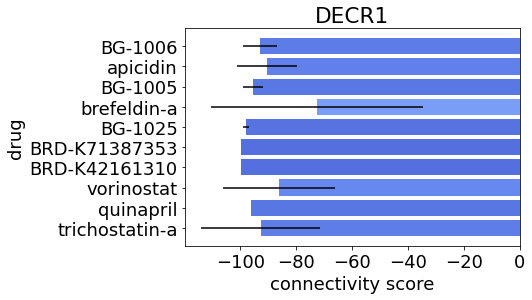

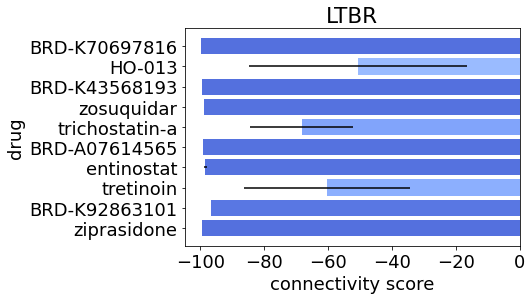

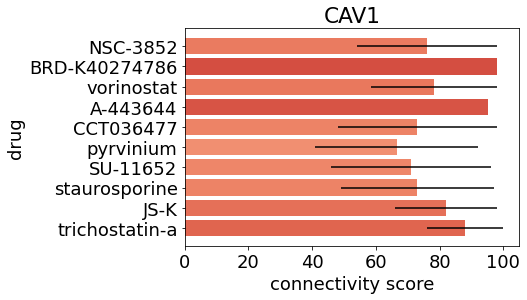

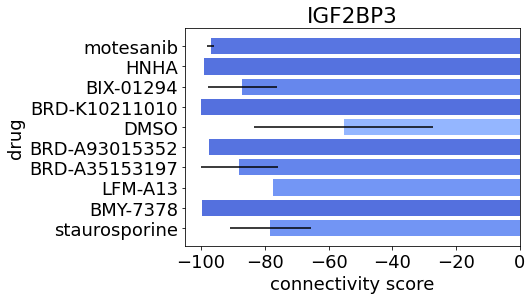

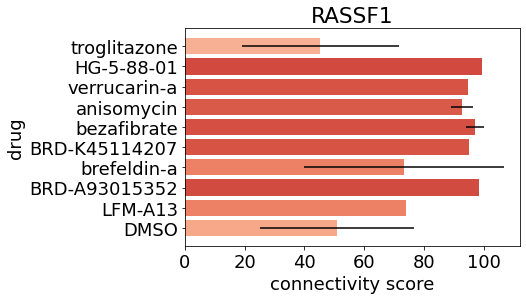

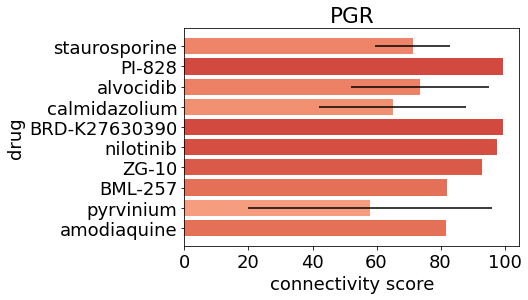

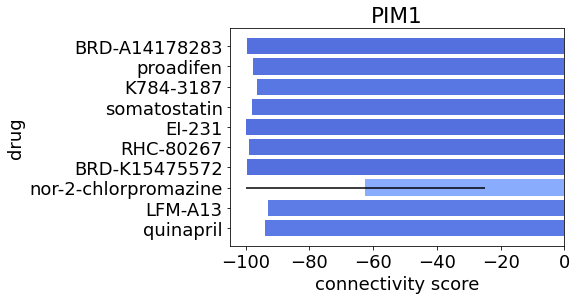

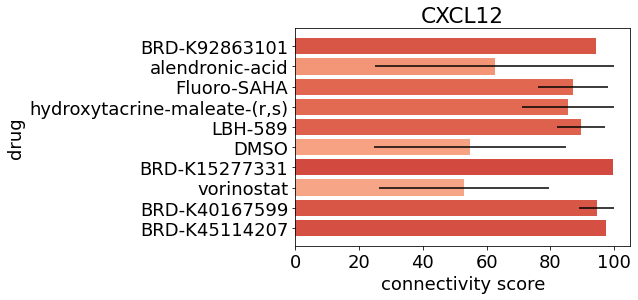

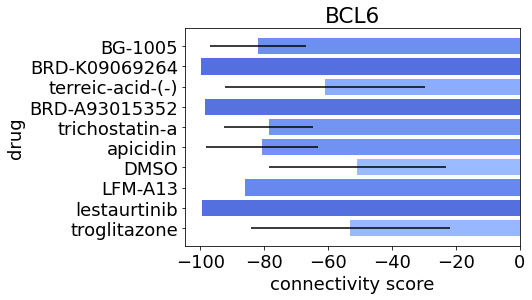

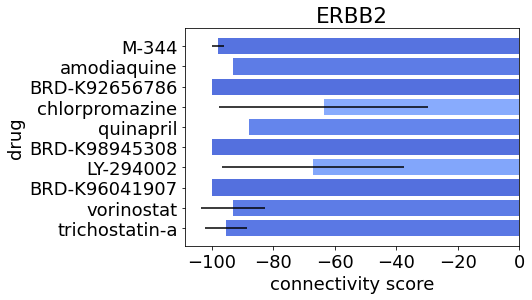

In [42]:
connectivity_df_list = []
for gene in gene_id_dict_short:
    connectivity_df = plot_connectivity_score(gene, gctoo_n_cond_df, gene_id_dict_short, sorted_cg_deg = sorted_cg_deg)
    connectivity_df_list.append(connectivity_df)

## Step 6: Query LINCS for drugs to target the top DEGs

In [43]:
deseq['abs_log2FC'] = np.abs(deseq['log2FoldChange']) # get absolute log2FC
deseq = deseq.sort_values('abs_log2FC', ascending = False)
deseq['drug_type'] = 'activator'
deseq.loc[deseq['log2FoldChange'] > 0, 'drug_type'] = 'inhibitor'

In [44]:
reverse_gene_id_dict = pd.Series(gene_info['pr_gene_id'].values, index = gene_info['pr_gene_symbol'].values).to_dict()
deseq = deseq.assign(pr_gene_id =  deseq['gene'].map(reverse_gene_id_dict))
top_deg = deseq[~deseq['pr_gene_id'].isna()]['pr_gene_id'][:10]

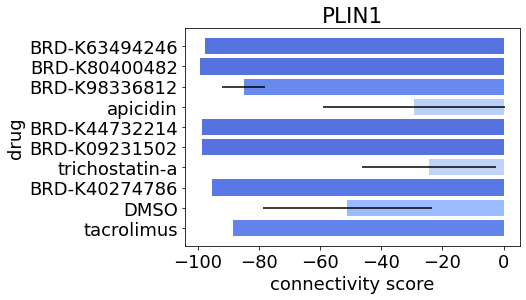

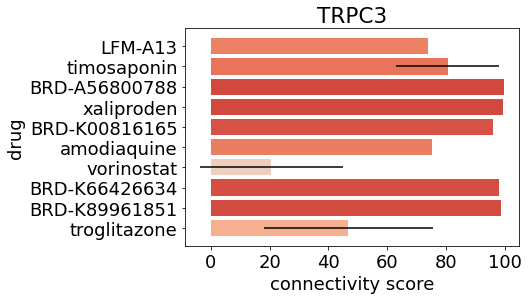

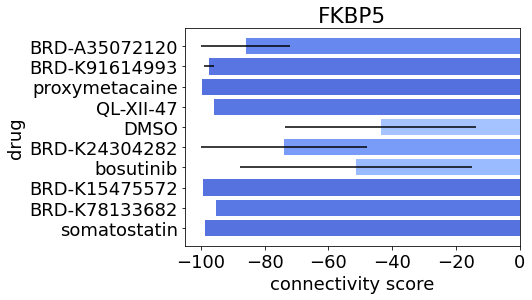

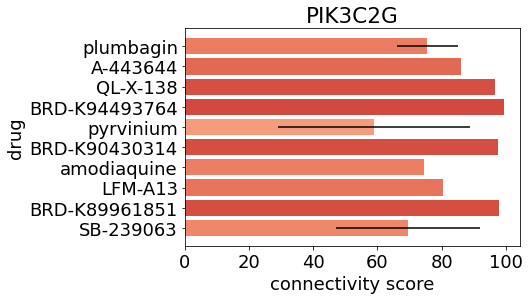

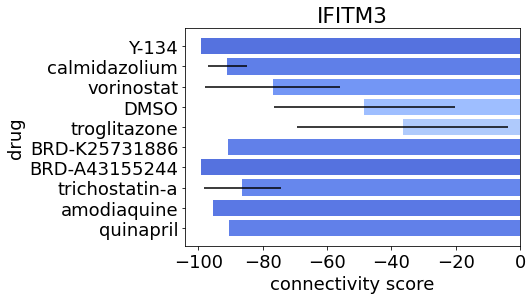

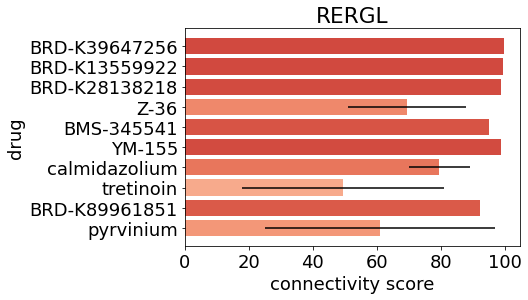

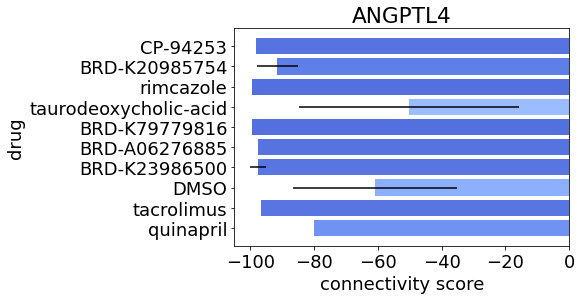

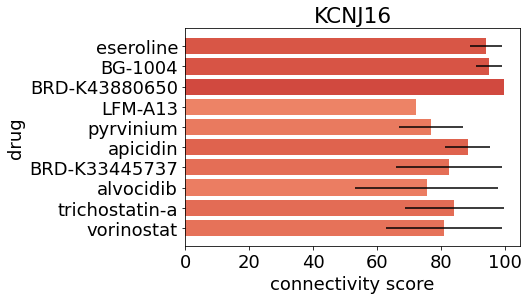

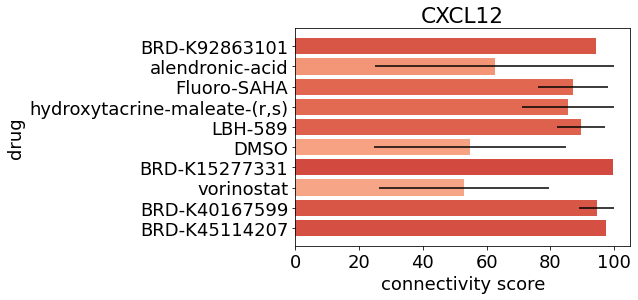

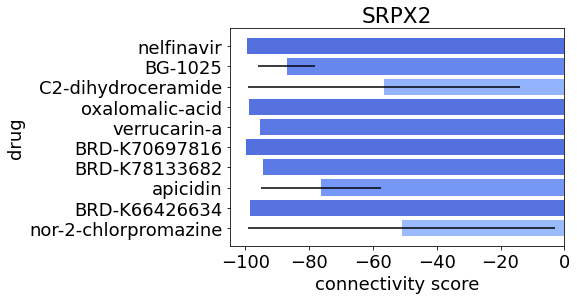

In [45]:
deg_connectivity_df_list = []
for gene in top_deg:
    connectivity_df = plot_connectivity_score(gene, gctoo_n_cond_df, gene_id_dict, deseq = deseq)
    deg_connectivity_df_list.append(connectivity_df)

## Step 7: Get the top drugs based on connectivity score and the standard deviation for the score

In [46]:
cg_connectivity_df = pd.concat(connectivity_df_list)
deg_connectivity_df = pd.concat(deg_connectivity_df_list)

In [63]:
cg_connectivity_df['drug'].unique().shape

(73,)

In [64]:
deg_connectivity_df['drug'].unique().shape

(75,)

In [66]:
len(set(cg_connectivity_df['drug'].unique()).intersection(set(deg_connectivity_df['drug'].unique())))

28

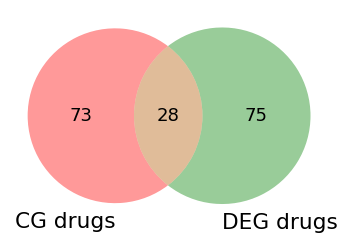

In [67]:
from matplotlib_venn import venn2
venn2(subsets = (73, 75, 28), set_labels = ('CG drugs', 'DEG drugs'))

In [48]:
# Get the absolute connectivity and  absolute std
cg_connectivity_df['abs score'] = np.abs(cg_connectivity_df['connectivity score'])
deg_connectivity_df['abs score'] = np.abs(deg_connectivity_df['connectivity score'])
cg_connectivity_df['abs std'] = np.abs(cg_connectivity_df['std'])
deg_connectivity_df['abs std'] = np.abs(deg_connectivity_df['std'])

In [51]:
# calculate std to connectivity ratio (if the std is relatively large, it should be treated as a weaker candidate)
cg_connectivity_df['std to score ratio'] = 100*cg_connectivity_df['abs std']/cg_connectivity_df['abs score']
deg_connectivity_df['std to score ratio'] = 100*deg_connectivity_df['abs std']/deg_connectivity_df['abs score']

In [49]:
from collections import Counter

In [52]:
cg_drug_count = Counter(cg_connectivity_df[(cg_connectivity_df['abs score'] > 85) & (cg_connectivity_df['std to score ratio'] < 15)]['drug'])
cg_drug_count = {k: v for k, v in sorted(cg_drug_count.items(), key=lambda item: item[1], reverse = True)}

In [53]:
deg_drug_count = Counter(deg_connectivity_df[(deg_connectivity_df['abs score'] > 85) & (deg_connectivity_df['std to score ratio'] < 15)]['drug'])
deg_drug_count = {k: v for k, v in sorted(deg_drug_count.items(), key=lambda item: item[1], reverse = True)}

In [54]:
len(cg_drug_count)

53

In [55]:
len(deg_drug_count)

54

In [56]:
len(set(cg_drug_count.keys()).intersection(set(deg_drug_count.keys())))

17

In [71]:
for drug in set(cg_drug_count.keys()).intersection(set(deg_drug_count.keys())):
    print(drug)

amodiaquine
trichostatin-a
BRD-K92863101
BG-1025
BRD-K40274786
LBH-589
apicidin
BRD-K45114207
BRD-K15475572
BRD-K40167599
A-443644
BRD-K15277331
verrucarin-a
Fluoro-SAHA
quinapril
BRD-K70697816
somatostatin


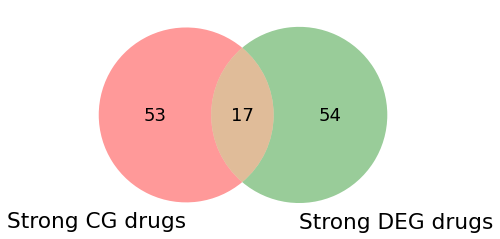

In [69]:
venn2(subsets = (53, 54, 17), set_labels = ('Strong CG drugs', 'Strong DEG drugs'))